# **Feature Engineering**

In [1]:
# Importing necessary libraries:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.utils import shuffle

In [2]:
# Reading the training dataset into a pandas dataframe:
data_train = pd.read_csv('mushroom_train.csv')
# Calculating the correlation of the numerical features:
corr_matrix = data_train.corr()
print("The correlation between the numerical columns of the features-\n", corr_matrix)

The correlation between the numerical columns of the features-
               cap-diameter  stem-height  stem-width
cap-diameter      1.000000     0.423171    0.695804
stem-height       0.423171     1.000000    0.436069
stem-width        0.695804     0.436069    1.000000


In [3]:
# Separating the categorical data:
categorical_col = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season','class']
categorical_data_train = data_train[categorical_col]
encoded_data_train = pd.get_dummies(categorical_data_train, prefix = categorical_col, prefix_sep = '_') # One-hot encoding.

**Standardizing the numerical features**

In [4]:
numerical_col_train = data_train[['cap-diameter', 'stem-height', 'stem-width']] # Separating the numerical columns.
scaler = StandardScaler()
numerical_col_scaled_train = scaler.fit_transform(numerical_col_train)
numerical_data_train = pd.DataFrame(numerical_col_scaled_train, columns = numerical_col_train.columns)

In [5]:
# Concatenating the columns (standardized numerical columns and the one-hot encoded categorical data) into one dataframe:
final_data_train = pd.concat([numerical_data_train, encoded_data_train], axis = 1)
df_temp = pd.DataFrame({'zeros': [0] * 42748})
df_temp.loc[final_data_train.iloc[:, -2] == 1, 'zeros'] = 0
df_temp.loc[final_data_train.iloc[:, -1] == 1, 'zeros'] = 1
final_data_train = final_data_train.drop(final_data_train.columns[-2:], axis = 1)
final_data_train_watch = pd.concat([final_data_train, df_temp], axis = 1)
final_data_train_watch = final_data_train_watch.rename(columns = {'<old_column_name>': 'label'})
new_data_train_watch = final_data_train_watch.reset_index()

# **Pearson's correlation**

In [6]:
# Separating the numerical columns:
cols_of_interest = ['stem-width', 'stem-height', 'cap-diameter']
corr_matrix = final_data_train.corr(method = 'pearson') # Computing the correlation matrix.
corr_filtered = corr_matrix[(corr_matrix.index.isin(cols_of_interest)) | (corr_matrix.columns.isin(cols_of_interest))] # Filtering out the correlation matrix to only include with 'stem-width', 'stem-height', or 'cap-diameter' columns.
# Creating a copy of the filtered correlation matrix to sort and to remove self-correlations:
corr_sorted = corr_filtered.abs().unstack().sort_values(ascending = False).reset_index()
corr_sorted = corr_sorted[corr_sorted['level_0'] != corr_sorted['level_1']]
corr_sorted.columns = ['Feature-1', 'Feature-2', 'Correlation coefficient']
corr_sorted_filtered = corr_sorted[(corr_sorted['Feature-1'].isin(cols_of_interest)) | (corr_sorted['Feature-2'].isin(cols_of_interest))]

# Printing the top 10 positively and top 10 negatively correlated features:
print("Top 10 positive correlations:\n", corr_sorted_filtered.head(10))
print("\nTop 10 negative correlations:\n", corr_sorted_filtered.tail(10)[::-1])

Top 10 positive correlations:
             Feature-1     Feature-2  Correlation coefficient
3        cap-diameter    stem-width                 0.695804
4          stem-width  cap-diameter                 0.695804
5         stem-height    stem-width                 0.436069
6          stem-width   stem-height                 0.436069
7         stem-height  cap-diameter                 0.423171
8        cap-diameter   stem-height                 0.423171
9         ring-type_m   stem-height                 0.406376
10  gill-attachment_p    stem-width                 0.400621
11  gill-attachment_p  cap-diameter                 0.353896
12        ring-type_f   stem-height                 0.332793

Top 10 negative correlations:
           Feature-1     Feature-2  Correlation coefficient
275    gill-color_o    stem-width                 0.000822
274     cap-color_e  cap-diameter                 0.000841
273    stem-color_u   stem-height                 0.000941
272     ring-type_l    stem-wi

In [7]:
new_data_train_watch = pd.concat([new_data_train_watch, df_temp], axis = 1)
# Reset the index of the DataFrame and creating a new column 'index':
new_data_train_watch.reset_index(inplace = True)
new_data_train_watch.rename(columns = {'index': 'index_column'}, inplace = True)

**Adding new features**

In [8]:
selected_rows_shape_m = new_data_train_watch[new_data_train_watch['ring-type_m'] == 1] # Selecting the rows where 'ring-type_m' is 1.
selected_data_m = pd.DataFrame(selected_rows_shape_m, columns = new_data_train_watch.columns) # Create a new dataframe with the selected rows.
selected_data_m = new_data_train_watch.loc[new_data_train_watch['ring-type_m'] == 1].copy()
# Computing the minimum, maximum and average of the corresponding numerical columns:
stem_width_min = selected_data_m['stem-width'].min()
stem_width_max = selected_data_m['stem-width'].max()
stem_width_mean = selected_data_m['stem-width'].mean()
selected_data_m['stem_width_ring_type_m_min'] = stem_width_min
selected_data_m['stem_width_ring_type_m_max'] = stem_width_max
selected_data_m['stem_width_ring_type_m_mean'] = stem_width_mean

selected_data_m = selected_data_m.rename(columns = {'zeros': 'label1'})
selected_data_m = selected_data_m.loc[:, ~selected_data_m.columns.duplicated()] # Deleting the duplicate <'label'> column.
selected_data_m = selected_data_m[['index_column', 'stem_width_ring_type_m_min', 'stem_width_ring_type_m_max', 'stem_width_ring_type_m_mean', 'label1']]

In [9]:
selected_rows_shape_p = new_data_train_watch[new_data_train_watch['gill-attachment_p'] == 1] 
selected_data = pd.DataFrame(selected_rows_shape_p, columns = new_data_train_watch.columns)
selected_data_p = new_data_train_watch.loc[new_data_train_watch['gill-attachment_p'] == 1].copy()

stem_width_min = selected_data_p['stem-width'].min()
stem_width_max = selected_data_p['stem-width'].max()
stem_width_mean = selected_data_p['stem-width'].mean()
selected_data_p['stem_width_gill_attachment_p_min'] = stem_width_min
selected_data_p['stem_width_gill_attachment_p_max'] = stem_width_max
selected_data_p['stem_width_gill_attachment_p_mean'] = stem_width_mean

selected_data_p = selected_data_p.rename(columns = {'zeros': 'label2'})
selected_data_p = selected_data_p.loc[:, ~selected_data_p.columns.duplicated()]
selected_data_p = selected_data_p[['index_column', 'stem_width_gill_attachment_p_min', 'stem_width_gill_attachment_p_max', 'stem_width_gill_attachment_p_mean', 'label2']]

In [10]:
selected_rows_shape_f = new_data_train_watch[new_data_train_watch['ring-type_f'] == 1]
selected_data = pd.DataFrame(selected_rows_shape_f, columns = new_data_train_watch.columns)
selected_data_f = new_data_train_watch.loc[new_data_train_watch['ring-type_f'] == 1].copy()

stem_height_min = selected_data_f['stem-height'].min()
stem_height_max = selected_data_f['stem-height'].max()
stem_height_mean = selected_data_f['stem-height'].mean()
selected_data_f['stem_height_ring_type_f_min'] = stem_height_min
selected_data_f['stem_height_ring_type_f_max'] = stem_height_max
selected_data_f['stem_height_ring_type_f_mean'] = stem_height_mean

selected_data_f = selected_data_f.rename(columns = {'zeros': 'label3'})
selected_data_f = selected_data_f.loc[:, ~selected_data_f.columns.duplicated()]
selected_data_f = selected_data_f[['index_column', 'stem_height_ring_type_f_min', 'stem_height_ring_type_f_max', 'stem_height_ring_type_f_mean', 'label3']]

In [11]:
selected_rows_shape_o = new_data_train_watch[new_data_train_watch['gill-color_o'] == 1]
selected_data = pd.DataFrame(selected_rows_shape_o, columns = new_data_train_watch.columns)
selected_data_o = new_data_train_watch.loc[new_data_train_watch['gill-color_o'] == 1].copy()

stem_width_min = selected_data_o['stem-width'].min()
stem_width_max = selected_data_o['stem-width'].max()
stem_width_mean = selected_data_o['stem-width'].mean()
selected_data_o['stem_width_gill_color_o_min'] = stem_width_min
selected_data_o['stem_width_gill_color_o_max'] = stem_width_max
selected_data_o['stem_width_gill_color_o_mean'] = stem_width_mean

selected_data_o = selected_data_o.rename(columns = {'zeros': 'label4'})
selected_data_o = selected_data_o.loc[:, ~selected_data_o.columns.duplicated()]
selected_data_o = selected_data_o[['index_column', 'stem_width_gill_color_o_min', 'stem_width_gill_color_o_max', 'stem_width_gill_color_o_mean', 'label4']]

In [12]:
selected_rows_shape_e = new_data_train_watch[new_data_train_watch['cap-color_e'] == 1]
selected_data = pd.DataFrame(selected_rows_shape_e, columns = new_data_train_watch.columns)
selected_data_e = new_data_train_watch.loc[new_data_train_watch['cap-color_e'] == 1].copy()

cap_diameter_min = selected_data_e['cap-diameter'].min()
cap_diameter_max = selected_data_e['cap-diameter'].max()
cap_diameter_mean = selected_data_e['cap-diameter'].mean()
selected_data_e['cap_diameter_cap_color_e_min'] = cap_diameter_min
selected_data_e['cap_diameter_cap_color_e_max'] = cap_diameter_max
selected_data_e['cap_diameter_cap_color_e_mean'] = cap_diameter_mean

selected_data_e = selected_data_e.rename(columns = {'zeros': 'label5'})
selected_data_e = selected_data_e.loc[:, ~selected_data_e.columns.duplicated()]
selected_data_e = selected_data_e[['index_column', 'cap_diameter_cap_color_e_min', 'cap_diameter_cap_color_e_max', 'cap_diameter_cap_color_e_mean', 'label5']]

In [13]:
selected_rows_shape_p_only = new_data_train_watch[new_data_train_watch['cap-shape_p'] == 1]
selected_data = pd.DataFrame(selected_rows_shape_p_only, columns = new_data_train_watch.columns)
selected_data_p_only = new_data_train_watch.loc[new_data_train_watch['cap-shape_p'] == 1].copy()

cap_diameter_min = selected_data_p_only['cap-diameter'].min()
cap_diameter_max = selected_data_p_only['cap-diameter'].max()
cap_diameter_mean = selected_data_p_only['cap-diameter'].mean()
selected_data_p_only['cap_diameter_p_min'] = cap_diameter_min
selected_data_p_only['cap_diameter_p_max'] = cap_diameter_max
selected_data_p_only['cap_diameter_p_mean'] = cap_diameter_mean

selected_data_p_only = selected_data_p_only.rename(columns = {'zeros': 'label6'})
selected_data_p_only = selected_data_p_only.loc[:, ~selected_data_p_only.columns.duplicated()]
selected_data_p_only = selected_data_p_only[['index_column', 'cap_diameter_p_min', 'cap_diameter_p_max', 'cap_diameter_p_mean', 'label6']]

In [14]:
dataframes = [new_data_train_watch, selected_data_m, selected_data_p, selected_data_f, selected_data_o, selected_data_e, selected_data_p_only]
concatenated_df = pd.concat(dataframes, axis = 1, join = 'outer') # Concatenating all the created dataframes based on a common index.
concatenated_df['common_index'] = concatenated_df.index
concatenated_df.fillna(0, inplace = True) # Replacing any Not-a-Number values with zeroes.
concatenated_df.set_index('common_index', inplace = True)
concatenated_df = concatenated_df.drop('index_column', axis = 1)
concatenated_df = concatenated_df.drop('level_0', axis = 1) # Dropping the common index column.
print("DataFrame with the all augmented features:\n", concatenated_df.columns)

DataFrame with the all augmented features:
 Index(['cap-diameter', 'stem-height', 'stem-width', 'cap-shape_b',
       'cap-shape_c', 'cap-shape_f', 'cap-shape_o', 'cap-shape_p',
       'cap-shape_s', 'cap-shape_x',
       ...
       'stem_width_gill_color_o_mean', 'label4',
       'cap_diameter_cap_color_e_min', 'cap_diameter_cap_color_e_max',
       'cap_diameter_cap_color_e_mean', 'label5', 'cap_diameter_p_min',
       'cap_diameter_p_max', 'cap_diameter_p_mean', 'label6'],
      dtype='object', length=118)


In [15]:
# Defining a function to check if any of the label columns has '1':
def has_label(row):
    label_cols = ['label1', 'label2', 'label3', 'label4', 'label5', 'label6']
    
    for col in label_cols:
        
        if row[col] == 1:
            return 1
    
    return 0

In [16]:
concatenated_df['label'] = concatenated_df.apply(has_label, axis = 1)
concatenated_df = concatenated_df.drop(['label1', 'label2', 'label3', 'label4','label5','label6'], axis = 1)
concatenated_df = concatenated_df.drop(['zeros'], axis = 1)
concatenated_df_train = concatenated_df # Final training dataframe.
label_column_train = concatenated_df_train.iloc[:, -1] # Labels of the final training dataframe. 

# **Principal Component Analysis**

In [17]:
pca = PCA(n_components = 13) # Defining the number of features to pass to the PCA function.
pcs = pca.fit_transform(concatenated_df_train)
top_feature_names = []

for comps in range(pca.n_components_):
    component_loadings = abs(pca.components_[comps])
    sorted_indices = component_loadings.argsort()[::-1]
    top_feature_indices = sorted_indices[:pca.n_components]
    top_feature_names.append(concatenated_df_train.columns[top_feature_indices].tolist())

all_top_feature_names = [name for sublist in top_feature_names for name in sublist] # Concatenating the lists of top feature names into a single list.
feature_counts = pd.Series(all_top_feature_names).value_counts().sort_values(ascending = False) # Counting the frequency of each feature and sorting in descending order.
top_features = feature_counts.index[:pca.n_components].tolist() # Extracting the most frequent features.
print("The optimal features determined by PCA-\n", top_features)

The optimal features determined by PCA-
 ['cap-shape_x', 'stem-width', 'cap-color_n', 'cap-diameter', 'stem-height', 'gill-attachment_a', 'stem-color_w', 'habitat_d', 'stem_width_gill_color_o_max', 'cap_diameter_p_max', 'gill-color_w', 'label', 'season_a']


In [18]:
# Accessing the indices of the columns that correspond to the top features and creating a new dataframe of only top features:
top_feature_indices = [concatenated_df_train.columns.get_loc(feature) for feature in top_features[:pca.n_components]]
top_features_data_train = concatenated_df_train.iloc[:, top_feature_indices]
print(top_features_data_train)

              cap-shape_x  stem-width  cap-color_n  cap-diameter  stem-height  \
common_index                                                                    
0                       0   -0.590488            0     -0.332216    -0.161276   
1                       1   -0.856362            0     -0.742182    -0.274093   
2                       1    1.316604            0      0.905345     0.132642   
3                       0    0.149160            0      0.393845    -0.636294   
4                       1    0.631930            1      0.160126     0.542345   
...                   ...         ...          ...           ...          ...   
42743                   0   -0.860360            0     -0.657890    -0.481913   
42744                   1   -0.099722            0      0.420665    -0.585823   
42745                   0    1.423554            0      7.495450    -0.247373   
42746                   0    1.225648            1      0.803811     0.287022   
42747                   0   

**Standardizing the testing dataset**

In [19]:
data_test = pd.read_csv('mushroom_test.csv')
categorical_col = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season','class']
categorical_data_test = data_test[categorical_col]
encoded_data_test = pd.get_dummies(categorical_data_test, prefix = categorical_col, prefix_sep = '_') # One-hot encoding the categorical values.
numerical_col_test = data_test[['cap-diameter', 'stem-height', 'stem-width']]
scaler = StandardScaler()
numerical_col_scaled_test = scaler.fit_transform(numerical_col_test)
numerical_data_test = pd.DataFrame(numerical_col_scaled_test, columns = numerical_col_test.columns)
final_data_test = pd.concat([numerical_data_test, encoded_data_test], axis = 1)

In [20]:
df_temp = pd.DataFrame({'zeros': [0] * (final_data_test.shape[0])})
df_temp.loc[final_data_test.iloc[:,-2] == 1, 'zeros'] = 0
df_temp.loc[final_data_test.iloc[:,-1] == 1, 'zeros'] = 1
final_data_test = final_data_test.drop(final_data_test.columns[-2:], axis = 1)
final_data_test_watch = pd.concat([final_data_test, df_temp], axis = 1)
final_data_test_watch = final_data_test_watch.rename(columns={'<old_column_name>': 'label'})
new_data_test_watch= final_data_test.reset_index()
new_data_test_watch.rename(columns = {'index': 'index_column'}, inplace = True)
new_data_test_watch = pd.concat([new_data_test_watch, df_temp], axis = 1)
new_data_test_watch.reset_index(inplace = True)
new_data_test_watch.rename(columns = {'index': 'index_column'}, inplace = True)

**Adding new features to the testing dataset**

In [21]:
selected_rows_shape_m_test = new_data_test_watch[new_data_test_watch['ring-type_m'] == 1]
selected_data_m_test = pd.DataFrame(selected_rows_shape_m_test, columns = new_data_test_watch.columns)
selected_data_m_test = new_data_test_watch.loc[new_data_test_watch['ring-type_m'] == 1].copy()

stem_width_min_test = selected_data_m_test['stem-width'].min()
stem_width_max_test = selected_data_m_test['stem-width'].max()
stem_width_mean_test = selected_data_m_test['stem-width'].mean()
selected_data_m_test['stem_width_ring_type_m_min'] = stem_width_min_test
selected_data_m_test['stem_width_ring_type_m_max'] = stem_width_max_test
selected_data_m_test['stem_width_ring_type_m_mean'] = stem_width_mean_test

selected_data_m_test = selected_data_m_test.rename(columns = {'zeros': 'label1'})
selected_data_m_test = selected_data_m_test.loc[:, ~selected_data_m_test.columns.duplicated()]
selected_data_m_test = selected_data_m_test[['index_column', 'stem_width_ring_type_m_min', 'stem_width_ring_type_m_max', 'stem_width_ring_type_m_mean', 'label1']]

In [22]:
selected_rows_shape_p_test = new_data_test_watch[new_data_test_watch['gill-attachment_p'] == 1]
selected_data_test = pd.DataFrame(selected_rows_shape_p_test, columns = new_data_test_watch.columns)
selected_data_p_test = new_data_test_watch.loc[new_data_test_watch['gill-attachment_p'] == 1].copy()

stem_width_min_test = selected_data_p_test['stem-width'].min()
stem_width_max_test = selected_data_p_test['stem-width'].max()
stem_width_mean_test = selected_data_p_test['stem-width'].mean()
selected_data_p_test['stem_width_gill_attachment_p_min'] = stem_width_min
selected_data_p_test['stem_width_gill_attachment_p_max'] = stem_width_max
selected_data_p_test['stem_width_gill_attachment_p_mean'] = stem_width_mean

selected_data_p_test = selected_data_p_test.rename(columns = {'zeros': 'label2'})
selected_data_p_test = selected_data_p_test.loc[:, ~selected_data_p_test.columns.duplicated()]
selected_data_p_test = selected_data_p_test[['index_column', 'stem_width_gill_attachment_p_min', 'stem_width_gill_attachment_p_max', 'stem_width_gill_attachment_p_mean', 'label2']]

In [23]:
selected_rows_shape_f_test = new_data_test_watch[new_data_test_watch['ring-type_f'] == 1]
selected_data_test = pd.DataFrame(selected_rows_shape_f_test, columns = new_data_test_watch.columns)
selected_data_f_test = new_data_test_watch.loc[new_data_test_watch['ring-type_f'] == 1].copy()

stem_height_min_test = selected_data_f_test['stem-height'].min()
stem_height_max_test = selected_data_f_test['stem-height'].max()
stem_height_mean_test = selected_data_f_test['stem-height'].mean()
selected_data_f_test['stem_height_ring_type_f_min'] = stem_height_min_test
selected_data_f_test['stem_height_ring_type_f_max'] = stem_height_max_test
selected_data_f_test['stem_height_ring_type_f_mean'] = stem_height_mean_test

selected_data_f_test = selected_data_f_test.rename(columns = {'zeros': 'label3'})
selected_data_f_test = selected_data_f_test.loc[:, ~selected_data_f_test.columns.duplicated()]
selected_data_f_test = selected_data_f_test[['index_column', 'stem_height_ring_type_f_min', 'stem_height_ring_type_f_max', 'stem_height_ring_type_f_mean', 'label3']]

In [24]:
selected_rows_shape_o_test = new_data_test_watch[new_data_test_watch['gill-color_o'] == 1]
selected_data_test = pd.DataFrame(selected_rows_shape_o_test, columns = new_data_test_watch.columns)
selected_data_o_test = new_data_test_watch.loc[new_data_test_watch['gill-color_o'] == 1].copy()

stem_width_min_test = selected_data_o_test['stem-width'].min()
stem_width_max_test = selected_data_o_test['stem-width'].max()
stem_width_mean_test = selected_data_o_test['stem-width'].mean()
selected_data_o_test['stem_width_gill_color_o_min'] = stem_width_min_test
selected_data_o_test['stem_width_gill_color_o_max'] = stem_width_max_test
selected_data_o_test['stem_width_gill_color_o_mean'] = stem_width_mean_test

selected_data_o_test = selected_data_o_test.rename(columns = {'zeros': 'label4'})
selected_data_o_test = selected_data_o_test.loc[:, ~selected_data_o_test.columns.duplicated()]
selected_data_o_test = selected_data_o_test[['index_column', 'stem_width_gill_color_o_min', 'stem_width_gill_color_o_max', 'stem_width_gill_color_o_mean', 'label4']]

In [25]:
selected_rows_shape_e_test = new_data_test_watch[new_data_test_watch['cap-color_e'] == 1]
selected_data_test = pd.DataFrame(selected_rows_shape_e_test, columns = new_data_test_watch.columns)
selected_data_e_test = new_data_test_watch.loc[new_data_test_watch['cap-color_e'] == 1].copy()

cap_diameter_min_test = selected_data_e_test['cap-diameter'].min()
cap_diameter_max_test = selected_data_e_test['cap-diameter'].max()
cap_diameter_mean_test = selected_data_e_test['cap-diameter'].mean()
selected_data_e_test['cap_diameter_cap_color_e_min'] = cap_diameter_min_test
selected_data_e_test['cap_diameter_cap_color_e_max'] = cap_diameter_max_test
selected_data_e_test['cap_diameter_cap_color_e_mean'] = cap_diameter_mean_test

selected_data_e_test = selected_data_e_test.rename(columns = {'zeros': 'label5'})
selected_data_e_test = selected_data_e_test.loc[:, ~selected_data_e_test.columns.duplicated()]
selected_data_e_test = selected_data_e_test[['index_column', 'cap_diameter_cap_color_e_min', 'cap_diameter_cap_color_e_max', 'cap_diameter_cap_color_e_mean', 'label5']]

In [26]:
selected_rows_shape_p_only_test = new_data_test_watch[new_data_test_watch['cap-shape_p'] == 1]
selected_data_test = pd.DataFrame(selected_rows_shape_p_only_test, columns = new_data_test_watch.columns)
selected_data_p_only_test = new_data_test_watch.loc[new_data_test_watch['cap-shape_p'] == 1].copy()

cap_diameter_min_test = selected_data_p_only_test['cap-diameter'].min()
cap_diameter_max_test = selected_data_p_only_test['cap-diameter'].max()
cap_diameter_mean_test = selected_data_p_only_test['cap-diameter'].mean()
selected_data_p_only_test['cap_diameter_p_min'] = cap_diameter_min_test
selected_data_p_only_test['cap_diameter_p_max'] = cap_diameter_max_test
selected_data_p_only_test['cap_diameter_p_mean'] = cap_diameter_mean_test

selected_data_p_only_test = selected_data_p_only_test.rename(columns = {'zeros': 'label6'})
selected_data_p_only_test = selected_data_p_only_test.loc[:, ~selected_data_p_only_test.columns.duplicated()]
selected_data_p_only_test = selected_data_p_only_test[['index_column', 'cap_diameter_p_min', 'cap_diameter_p_max', 'cap_diameter_p_mean', 'label6']]

In [27]:
dataframes_test = [new_data_test_watch, selected_data_m_test, selected_data_p_test, selected_data_f_test, selected_data_o_test, selected_data_e_test, selected_data_p_only_test]
concatenated_df_test = pd.concat(dataframes_test, axis = 1, join = 'outer')
concatenated_df_test = concatenated_df_test.drop('index_column', axis = 1)

In [28]:
concatenated_df_test['common_index'] = concatenated_df_test.index
concatenated_df_test.fillna(0, inplace = True)
concatenated_df_test.set_index('common_index', inplace = True)

def has_label(row):
    label_cols = ['label1', 'label2', 'label3', 'label4', 'label5', 'label6']
    
    for col in label_cols:
        
        if row[col] == 1:
            return 1
    return 0

concatenated_df_test['label'] = concatenated_df_test.apply(has_label, axis = 1)
concatenated_df_test = concatenated_df_test.drop(['label1', 'label2', 'label3', 'label4','label5','label6'], axis = 1)
concatenated_df_test = concatenated_df_test.drop(['zeros'], axis = 1)
last_column_test = concatenated_df_test.iloc[:, -1]
last_column_test = concatenated_df_test.iloc[:, -1].reset_index(drop = True)

In [29]:
# Extracting the indices of the columns in top PCA features training dataset to append to the testing dataset:
top_feature_indices_test = [concatenated_df_test.columns.get_loc(feature) for feature in top_features[:pca.n_components]]
top_features_data_test = concatenated_df_test.iloc[:, top_feature_indices_test]
print("The final testing dataset-\n", top_features_data_test)

The final testing dataset-
               cap-shape_x  stem-width  cap-color_n  cap-diameter  stem-height  \
common_index                                                                    
0                       0    0.989005            0      1.335793     0.323775   
1                       0    2.393873            1      2.051180    -0.055604   
2                       1   -1.066850            1     -0.983626    -0.378668   
3                       1    1.422338            1      1.592885    -0.420163   
4                       0    0.720893            0      1.710253     5.036366   
...                   ...         ...          ...           ...          ...   
18316                   1   -0.422788            1      0.089454     0.409728   
18317                   1    2.589763            1      2.710678     3.231355   
18318                   0   -0.835344            1     -0.769383     0.566814   
18319                   0    0.978122            0      1.484832     0.540139   


In [30]:
# Defining the X & y training components: 
X_train = top_features_data_train
true_labels = label_column_train
# Defining the X & y testing components:
X_test = top_features_data_test
y_test = pd.DataFrame(last_column_test)
y_test = y_test['label'].values
X_train_v, X_val, y_train, y_val = train_test_split(X_train, true_labels, test_size = 0.2, random_state = 42) # Splitting the training dataset into validation set (80/20).
k = 5

**Logistic Regression on PCA reduced dataset**

In [31]:
# Performing Logistic Regression on the final dataframes:
logreg = LogisticRegression(max_iter = 1000)
scores = cross_val_score(logreg, X_train_v, y_train, cv = k)
logreg.fit(X_train_v, y_train)
#print("Average cross-validation accuracy: {:.2f}%".format(scores.mean() * 100))
# Predicting the class labels of the testing dataset:
#predicted_labels = logreg.predict(X_test)
val_accuracy = logreg.score(X_val, y_val)
train_accuracy = logreg.score(X_train_v, y_train)
print(f"The validation accuracy of logistic regression = {val_accuracy * 100}%")
print(f"The training accuracy of logistic regression = {train_accuracy * 100}%")
#accuracy = accuracy_score(predicted_labels, y_test) # Calculating the accuracy.
#print(f"The accuracy of logistic regression = {accuracy * 100}%")
#print(classification_report(y_test, predicted_labels))

The validation accuracy of logistic regression = 100.0%
The training accuracy of logistic regression = 100.0%


**Random Forest Classifier on PCA reduced dataset**

In [32]:
rf = RandomForestClassifier()
scores_rf = cross_val_score(rf, X_train_v, y_train, cv = k)
rf.fit(X_train_v, y_train)
val_accuracy_rf = rf.score(X_val, y_val)
train_accuracy_rf = rf.score(X_train_v, y_train)
#predicted_labels_rf = rf.predict(X_test)
print(f"The validation accuracy of random forest classifier = {val_accuracy_rf * 100}%")
print(f"The training accuracy of random forest classifier = {train_accuracy_rf * 100}%")
#accuracy_rf = accuracy_score(predicted_labels_rf, y_test)
#print(f"The accuracy of random forest classifier = {accuracy_rf * 100}%")
#print(classification_report(y_test, predicted_labels_rf))

The validation accuracy of random forest classifier = 100.0%
The training accuracy of random forest classifier = 100.0%


**Support Vector Machine on PCA reduced dataset**

In [33]:
svm = SVC(kernel = 'rbf', C = 1, gamma = 3)
scores_svm = cross_val_score(svm, X_train_v, y_train, cv = k)
svm.fit(X_train_v, y_train)
val_accuracy_svm = svm.score(X_val, y_val)
train_accuracy_svm = svm.score(X_train_v, y_train)
print(f"The validation accuracy of support vector machine =  {val_accuracy_svm * 100}%")
print(f"The training accuracy of support vector machine = {train_accuracy_svm * 100}%")
#predicted_labels_svm = svm.predict(X_test)
#print(f"The accuracy of support vector machine = {accuracy_score(predicted_labels_svm, y_test) * 100}%")
#print(classification_report(y_test, predicted_labels_svm))

The validation accuracy of support vector machine =  99.89473684210526%
The training accuracy of support vector machine = 100.0%


In [34]:
y_pred = svm.predict(X_test)
print(accuracy_score(y_pred, y_test))

0.9990721030511435


**Naive Bayes on PCA data**

In [35]:
bayes = GaussianNB()
scores_bayes = cross_val_score(bayes, X_train_v, y_train, cv = k)
bayes.fit(X_train_v, y_train)
val_accuracy_bayes = bayes.score(X_val, y_val)
train_accuracy_bayes = bayes.score(X_train_v, y_train)
print(f"The validation accuracy of naive bayes classifier = {val_accuracy_bayes * 100}%")
print(f"The training accuracy of naive bayes classifier = {train_accuracy_bayes * 100}%")
#pred_target = bayes.predict(X_test)
#accuracy_nb = accuracy_score(pred_target, y_test)
#print(f"The accuracy of naive bayes = {accuracy_nb * 100}%")
#print(classification_report(y_test, pred_target))

The validation accuracy of naive bayes classifier = 100.0%
The training accuracy of naive bayes classifier = 100.0%


In [36]:
import tensorflow as tf
from tensorflow import keras

# Define the MLP model architecture
model = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
history = model.fit(X_train_v, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val)
print('Test accuracy:', val_acc)


Epoch 1/10
1069/1069 [==============================] - 2s 987us/step - loss: 0.0480 - accuracy: 0.9888 - val_loss: 2.2115e-04 - val_accuracy: 1.0000
Epoch 2/10
1069/1069 [==============================] - 1s 888us/step - loss: 9.8923e-05 - accuracy: 1.0000 - val_loss: 4.5921e-05 - val_accuracy: 1.0000
Epoch 3/10
1069/1069 [==============================] - 1s 873us/step - loss: 2.6717e-05 - accuracy: 1.0000 - val_loss: 1.6437e-05 - val_accuracy: 1.0000
Epoch 4/10
1069/1069 [==============================] - 1s 870us/step - loss: 1.0475e-05 - accuracy: 1.0000 - val_loss: 7.1340e-06 - val_accuracy: 1.0000
Epoch 5/10
1069/1069 [==============================] - 1s 869us/step - loss: 4.7966e-06 - accuracy: 1.0000 - val_loss: 3.4539e-06 - val_accuracy: 1.0000
Epoch 6/10
1069/1069 [==============================] - 1s 917us/step - loss: 2.3695e-06 - accuracy: 1.0000 - val_loss: 1.7575e-06 - val_accuracy: 1.0000
Epoch 7/10
1069/1069 [==============================] - 1s 925us/step - loss: 1.

# **Univariate Feature Selection**

In [37]:
del concatenated_df_test['label']
del concatenated_df_train['label']
ufs = SelectKBest(score_func = chi2, k = 10)
ufs.fit(abs(concatenated_df_train), label_column_train)
X_train_selected = ufs.transform(concatenated_df_train)
X_test_selected = ufs.transform(concatenated_df_test)
X_train_v, X_val, y_train, y_val = train_test_split(X_train_selected, label_column_train, test_size = 0.2, random_state = 42) # Splitting the training dataset into validation set (80/20).
k = 5

**Logistic Regression on UFS data**

In [38]:
lr = LogisticRegression()
scores = cross_val_score(lr, X_train_v, y_train, cv = k)
lr.fit(X_train_v, y_train)
val_accuracy = lr.score(X_val, y_val)
train_accuracy_lr = lr.score(X_train_v, y_train)
print(f"The validation accuracy of logistic regression = {val_accuracy * 100}%")
print(f"The training accuracy of logistic regression = {train_accuracy_lr * 100}%")
#predicted_labels_lr_ufs = lr.predict(X_test_selected)
#accuracy_lr_ufs = accuracy_score(last_column_test, predicted_labels_lr_ufs)
#print(f"The accuracy of logistic regression = {accuracy_lr_ufs * 100}%")
#print(classification_report(last_column_test, predicted_labels_lr_ufs))

The validation accuracy of logistic regression = 72.44444444444444%
The training accuracy of logistic regression = 73.53353997309785%


Fold 1/5
The validation accuracy of logistic regression in this fold = 72.44444444444444%
The training accuracy of logistic regression in this fold = 73.53353997309785%
Fold 2/5
The validation accuracy of logistic regression in this fold = 73.82456140350877%
The training accuracy of logistic regression in this fold = 73.18849055500321%
Fold 3/5
The validation accuracy of logistic regression in this fold = 73.6140350877193%
The training accuracy of logistic regression in this fold = 73.2411252120007%
Fold 4/5
The validation accuracy of logistic regression in this fold = 73.66943502163996%
The training accuracy of logistic regression in this fold = 73.22728734758326%
Fold 5/5
The validation accuracy of logistic regression in this fold = 73.02608492221312%
The training accuracy of logistic regression in this fold = 73.38811076347261%


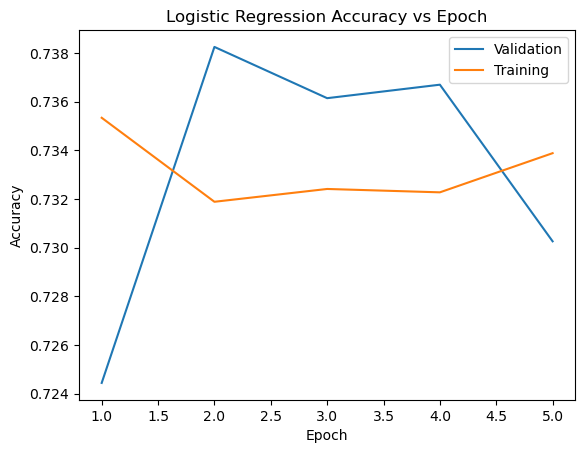

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2

# Splitting the data into train and test sets
ufs = SelectKBest(score_func=chi2, k=10)
ufs.fit(abs(concatenated_df_train), label_column_train)
X_train_selected = ufs.transform(concatenated_df_train)
X_test_selected = ufs.transform(concatenated_df_test)

# Applying k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

val_acc_list = []
train_acc_list = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train_selected)):
    print(f'Fold {fold+1}/{k}')

    # Splitting the data into train and validation sets for this fold
    X_train_v, X_val = X_train_selected[train_index], X_train_selected[val_index]
    y_train, y_val = label_column_train[train_index], label_column_train[val_index]

    # Training the model
    lr = LogisticRegression()
    lr.fit(X_train_v, y_train)

    # Evaluating the model on the validation set
    val_accuracy = lr.score(X_val, y_val)
    train_accuracy = lr.score(X_train_v, y_train)
    val_acc_list.append(val_accuracy)
    train_acc_list.append(train_accuracy)
    print(f"The validation accuracy of logistic regression in this fold = {val_accuracy * 100}%")
    print(f"The training accuracy of logistic regression in this fold = {train_accuracy * 100}%")

# Plotting the training and validation accuracy vs epoch
epochs = np.arange(1, k+1)
plt.plot(epochs, val_acc_list, label='Validation')
plt.plot(epochs, train_acc_list, label='Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Accuracy vs Epoch')
plt.legend()
plt.show()


**Support Vector Machine on UFS data**

In [39]:
svm_ufs = SVC(kernel = 'rbf', C = 1, gamma = 3)
scores_ufs = cross_val_score(svm_ufs, X_train_v, y_train, cv = k)
svm_ufs.fit(X_train_v, y_train)
val_accuracy_ufs = svm_ufs.score(X_val, y_val)
train_accuracy_svm = svm_ufs.score(X_train_v, y_train)
print(f"The validation accuracy of support vector machine = {val_accuracy_ufs * 100}%")
print(f"The training accuracy of support vector machine = {train_accuracy_svm * 100}%")
#predicted_labels_lr_svm = svm_ufs.predict(X_test_selected)
#print(f"The accuracy of support vector machine = {accuracy_score(predicted_labels_lr_svm, last_column_test) * 100}%")
#print(classification_report(last_column_test, predicted_labels_lr_svm))

The validation accuracy of support vector machine = 74.53801169590643%
The training accuracy of support vector machine = 75.38744955845371%


The average training accuracy of support vector machine = 75.22106266080748%
The average validation accuracy of support vector machine = 75.18012010569959%


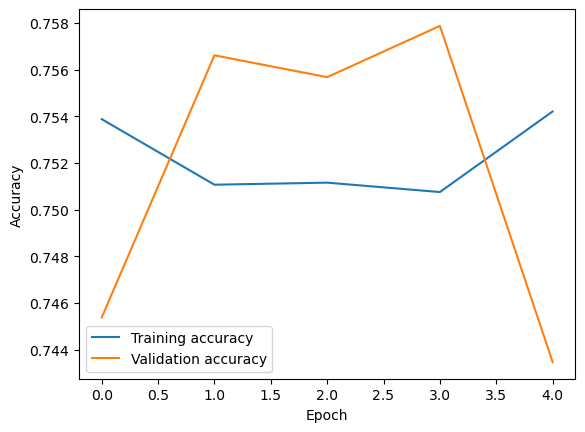

In [45]:
from sklearn.model_selection import KFold

svm_ufs = SVC(kernel='rbf', C=1, gamma=3)
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
train_accs = []
val_accs = []

for train_index, val_index in kf.split(X_train_selected):
    X_train, X_val = X_train_selected[train_index], X_train_selected[val_index]
    y_train, y_val = label_column_train[train_index], label_column_train[val_index]
    
    svm_ufs.fit(X_train, y_train)
    train_accuracy_svm = svm_ufs.score(X_train, y_train)
    train_accs.append(train_accuracy_svm)
    val_accuracy_ufs = svm_ufs.score(X_val, y_val)
    val_accs.append(val_accuracy_ufs)
    
print(f"The average training accuracy of support vector machine = {np.mean(train_accs) * 100}%")
print(f"The average validation accuracy of support vector machine = {np.mean(val_accs) * 100}%")

# plot the training and validation accuracy vs epoch
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(train_accs, label='Training accuracy')
ax.plot(val_accs, label='Validation accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

**Random Forest Classifier on UFS data**

In [40]:
rf_ufs = RandomForestClassifier()
scores_rf_ufs = cross_val_score(rf_ufs, X_train_v, y_train, cv = k)
rf_ufs.fit(X_train_v, y_train)
val_accuracy_ufs_rf = rf_ufs.score(X_val, y_val)
train_accuracy_RF = rf_ufs.score(X_train_v, y_train)
print(f"The validation accuracy of random forest classifier = {val_accuracy_ufs_rf * 100}%")
print(f"The training accuracy of random forest classifier = {train_accuracy_RF * 100}%")
#predicted_labels_rf_ufs = rf_ufs.predict(X_test_selected)
#accuracy_rf_ufs = accuracy_score(predicted_labels_rf_ufs, last_column_test)
#print(f"The accuracy of random forest classifier = {accuracy_rf_ufs * 100}%")
#print(classification_report(last_column_test, predicted_labels_rf_ufs))

The validation accuracy of random forest classifier = 74.53801169590643%
The training accuracy of random forest classifier = 75.38744955845371%


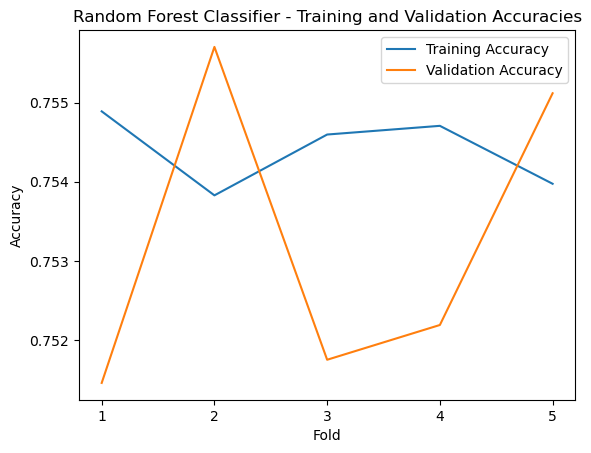

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt

# Initializing the random forest classifier
rf_ufs = RandomForestClassifier()

# Performing k-fold cross validation and getting the accuracy scores for each fold
k = 5
scores_rf_ufs = []
train_acc_rf_ufs = []
val_acc_rf_ufs = []
for i in range(k):
    # Get the training and validation data for this fold
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train_v, y_train, test_size=0.2, random_state=i)
    
    # Train the model on the training data for this fold
    rf_ufs.fit(X_train_fold, y_train_fold)
    
    # Get the accuracy scores for this fold
    train_acc_rf_ufs.append(rf_ufs.score(X_train_fold, y_train_fold))
    val_acc_rf_ufs.append(rf_ufs.score(X_val_fold, y_val_fold))
    scores_rf_ufs.append(rf_ufs.score(X_val_fold, y_val_fold))

# Plotting the training and validation accuracies for each fold
plt.plot(range(1, k+1), train_acc_rf_ufs, label='Training Accuracy')
plt.plot(range(1, k+1), val_acc_rf_ufs, label='Validation Accuracy')
plt.title('Random Forest Classifier - Training and Validation Accuracies')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, k+1))
plt.legend()
plt.show()

**Naive Bayes on UFS data**

In [41]:
bayes_ufs = GaussianNB()
scores_rf_bayes = cross_val_score(bayes_ufs, X_train_v, y_train, cv = k)
bayes_ufs.fit(X_train_v, y_train)
val_accuracy_ufs_bayes = bayes_ufs.score(X_val, y_val)
train_accuracy_bayes = bayes_ufs.score(X_train_v, y_train)
print(f"The validation accuracy of naive bayes classifier = {val_accuracy_ufs_bayes * 100}%")
print(f"The training accuracy of naive bayes classifier = {train_accuracy_bayes * 100}%")
#pred_target_ufs = bayes_ufs.predict(X_test_selected)
#accuracy_nb_ufs = accuracy_score(pred_target_ufs, last_column_test)
#print(f"The accuracy of naive bayes = {accuracy_nb_ufs * 100}%")
#print(classification_report(last_column_test, pred_target_ufs))

The validation accuracy of naive bayes classifier = 64.66666666666666%
The training accuracy of naive bayes classifier = 66.04772208901105%


Epoch 1/50 - Training Accuracy: 69.11%, Validation Accuracy: 61.00%
Epoch 2/50 - Training Accuracy: 69.11%, Validation Accuracy: 61.00%
Epoch 3/50 - Training Accuracy: 69.11%, Validation Accuracy: 61.00%
Epoch 4/50 - Training Accuracy: 69.11%, Validation Accuracy: 61.00%
Epoch 5/50 - Training Accuracy: 69.11%, Validation Accuracy: 61.00%
Epoch 6/50 - Training Accuracy: 69.11%, Validation Accuracy: 61.00%
Epoch 7/50 - Training Accuracy: 69.11%, Validation Accuracy: 61.00%
Epoch 8/50 - Training Accuracy: 69.11%, Validation Accuracy: 61.00%
Epoch 9/50 - Training Accuracy: 69.11%, Validation Accuracy: 61.00%
Epoch 10/50 - Training Accuracy: 69.11%, Validation Accuracy: 61.00%
Epoch 11/50 - Training Accuracy: 69.11%, Validation Accuracy: 61.00%
Epoch 12/50 - Training Accuracy: 69.11%, Validation Accuracy: 61.00%
Epoch 13/50 - Training Accuracy: 69.11%, Validation Accuracy: 61.00%
Epoch 14/50 - Training Accuracy: 69.11%, Validation Accuracy: 61.00%
Epoch 15/50 - Training Accuracy: 69.11%, Va

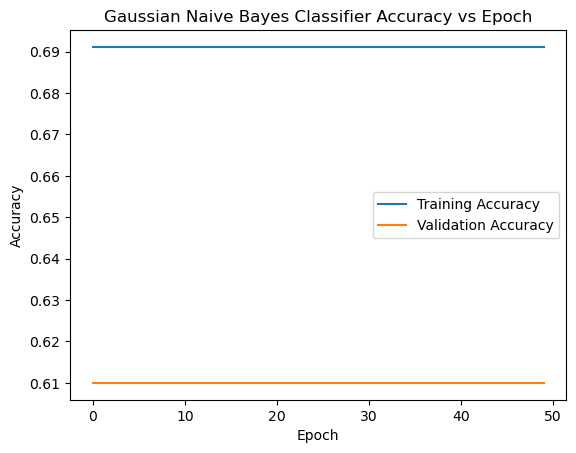

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, KFold


k = 10
n_epochs = 50

bayes_ufs = GaussianNB()
train_accs = []
val_accs = []

kf = KFold(n_splits=k)

for epoch in range(n_epochs):
    train_acc = 0
    val_acc = 0
    for train_index, val_index in kf.split(X_train_v, y_train):
        X_train_fold, X_val_fold = X_train_v[train_index], X_train_v[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        bayes_ufs.fit(X_train_fold, y_train_fold)
        train_acc += bayes_ufs.score(X_train_fold, y_train_fold)
        val_acc += bayes_ufs.score(X_val_fold, y_val_fold)

    train_acc /= k
    val_acc /= k
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{n_epochs} - Training Accuracy: {train_acc*100:.2f}%, Validation Accuracy: {val_acc*100:.2f}%")

plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Gaussian Naive Bayes Classifier Accuracy vs Epoch')
plt.legend()
plt.show()


In [42]:
import tensorflow as tf
from tensorflow import keras

# Define the MLP model architecture
model = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
history = model.fit(X_train_v, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val)
print('Test accuracy:', val_acc)

Epoch 1/10


ValueError: in user code:

    File "C:\Users\Kranti\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Kranti\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Kranti\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Kranti\anaconda3\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Kranti\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Kranti\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 13), found shape=(None, 10)
